# Import Necessary Libraries

In [1]:
# imports ...
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf # ml framework
tf.enable_eager_execution() # operations are executed immediately as they are called from Python
import numpy as np # linear algebra
import warnings
from PIL import Image # image processing library
import IPython.display as display # for inspecting the images by displaying them in the kernel
import random # for the random seed used as input for the generator
from numpy.random import choice
import matplotlib.pyplot as plt, zipfile # plotting library
import xml.etree.ElementTree as ET # xml parser used during pre-processing stage
import time # time the execution of codeblocks
import xml.dom.minidom # for printing the annotation xml nicely
import pydot
import graphviz
from IPython.display import FileLink, FileLinks

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, glob # for managing files/directories
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


In [2]:
tf.__version__

'1.14.0'

# Variable Declarations

In [3]:
# So it is easier to navigate throughout the notebook whenever I need to change variables

# Filepaths for image loading code
ROOT = '../input/'
# list of all image file names in all-dogs
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs')
# list of all the annotation directories, each directory is a dog breed
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

# Variables that determine how tensorflow will create batches after data load
BUFFER_SIZE = 20000
BATCH_SIZE = 32

# Weight initializers for the Generator network
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

# Image dimensions, generator outputs 64x64 size image while the discriminator expects a 64x64
dim = 64

# Variables needed for the training part
EPOCHS = 280
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Get images and pre-process

In [4]:
# Demo: Show how the Annotation files XML is structured
dom = xml.dom.minidom.parse('../input/annotation/Annotation/n02097658-silky_terrier/n02097658_98') 
pretty_xml_as_string = dom.toprettyxml()
print(pretty_xml_as_string)

<?xml version="1.0" ?>
<annotation>
	
	
	<folder>02097658</folder>
	
	
	<filename>n02097658_98</filename>
	
	
	<source>
		
		
		<database>ImageNet database</database>
		
	
	</source>
	
	
	<size>
		
		
		<width>500</width>
		
		
		<height>400</height>
		
		
		<depth>3</depth>
		
	
	</size>
	
	
	<segment>0</segment>
	
	
	<object>
		
		
		<name>silky_terrier</name>
		
		
		<pose>Unspecified</pose>
		
		
		<truncated>0</truncated>
		
		
		<difficult>0</difficult>
		
		
		<bndbox>
			
			
			<xmin>93</xmin>
			
			
			<ymin>117</ymin>
			
			
			<xmax>269</xmax>
			
			
			<ymax>289</ymax>
			
		
		</bndbox>
		
	
	</object>
	
	
	<object>
		
		
		<name>silky_terrier</name>
		
		
		<pose>Unspecified</pose>
		
		
		<truncated>0</truncated>
		
		
		<difficult>0</difficult>
		
		
		<bndbox>
			
			
			<xmin>290</xmin>
			
			
			<ymin>104</ymin>
			
			
			<xmax>393</xmax>
			
			
			<ymax>244</ymax>
			
		
		</bndbox>
		
	
	</object>
	

</annotation>



Thanks to Chris Deotte for the following snippet and Paulo Pinto for posting code on retrieving bounding boxes.

In [5]:
# Code slightly modified from user: cdeotte | https://www.kaggle.com/cdeotte/supervised-generative-dog-net

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# iterate through each directory in annotation
for breed in breeds:
    # iterate through each file in the directory
    for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
        try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
        except: continue           
        # Element Tree library allows for parsing xml and getting specific tag values    
        tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
        # take a look at the print out of an xml previously to get what is going on
        root = tree.getroot() # <annotation>
        objects = root.findall('object') # <object>
        for o in objects:
            bndbox = o.find('bndbox') # <bndbox>
            xmin = int(bndbox.find('xmin').text) # <xmin>
            ymin = int(bndbox.find('ymin').text) # <ymin>
            xmax = int(bndbox.find('xmax').text) # <xmax>
            ymax = int(bndbox.find('ymax').text) # <ymax>
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1                

In [6]:
# Inspect what the previous code created
print("imagesIn is a {} with {} {} by {} rgb({}) images. Shape: {}".format(type(imagesIn), imagesIn.shape[0], imagesIn.shape[1], imagesIn.shape[2], imagesIn.shape[3], imagesIn.shape))

imagesIn is a <class 'numpy.ndarray'> with 25000 64 by 64 rgb(3) images. Shape: (25000, 64, 64, 3)


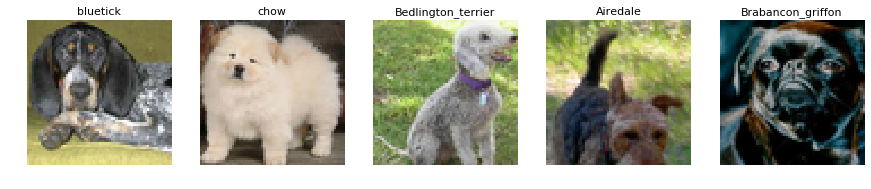

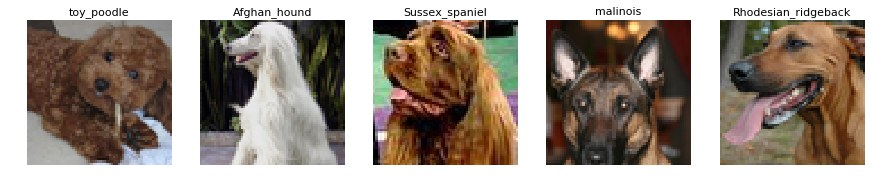

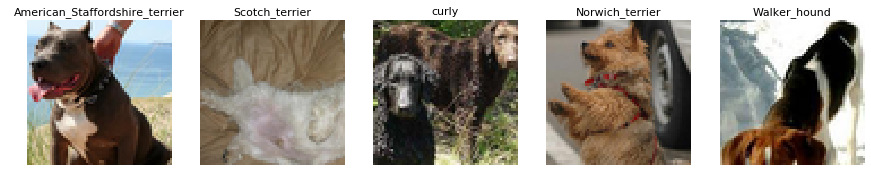

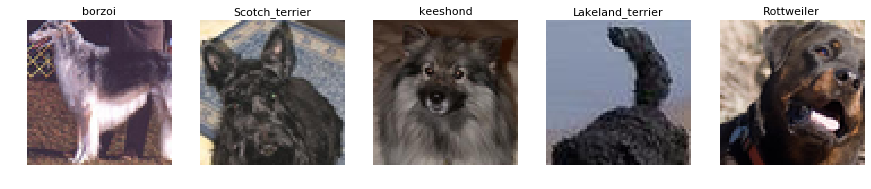

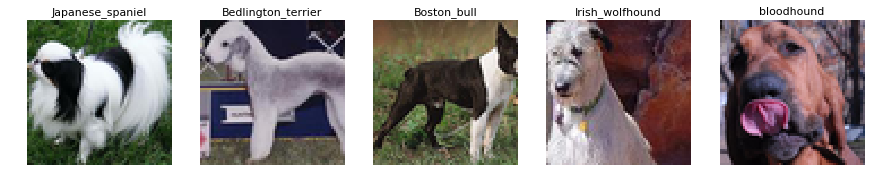

In [7]:
# DISPLAY CROPPED IMAGES

# list of 25 random numbers in range 0, idxIn
# this allows for displaying random images in the for loop using x[k*5+j]
x = np.random.randint(0,idxIn,25)

for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [8]:
# normalize the pixel values
imagesIn = (imagesIn[:idxIn,:,:,:]-127.5)/127.5

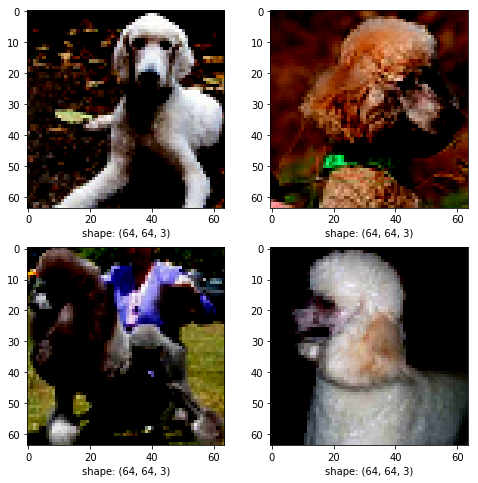

In [9]:
# view some images in the after normalization 
plt.figure(figsize=(8,8))
for image in range(4):
    plt.subplot(2,2, image+1)
    plt.imshow((imagesIn[image]))
    plt.xlabel('shape: {}'.format(imagesIn[image].shape))


**Create Dataset**

In [10]:
# this is needed because the gradient functions from TF require float32 instead of float64
imagesIn = tf.cast(imagesIn, 'float32')

The batch sizes will be a "hyperparameter" to experiment with for better performance.

In [11]:
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)

<DatasetV1Adapter shapes: (?, 64, 64, 3), types: tf.float32>


# Generator Model

Similar to this image is what the Generator network is doing
![](https://cdn-images-1.medium.com/max/1043/1*KvMnRfb76DponICrHIbSdg.png)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

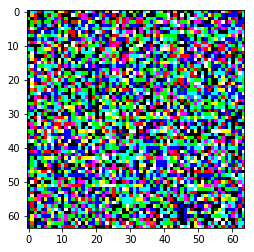

In [12]:
# function will return a generator model
def make_generator():
    model = tf.keras.Sequential(
        [
            # first layer with 32,768 nodes expecting an input of vector size 100 (random noise)
            tf.keras.layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
            # Normalize the activations of the previous layer at each batch
            tf.keras.layers.BatchNormalization(),
            # apply leaky relu activation: f(x) = {x if x > 0 : 0.01*x}
            tf.keras.layers.LeakyReLU(),
            # reshape input to (8,8,512)
            tf.keras.layers.Reshape((8, 8, 512)),
            
            # second layer Conv2DTranspose so it is doing the opposite of a convolutional layer
            tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Dense(3,activation='tanh', use_bias=False,\
                kernel_initializer=WEIGHT_INIT)
        ]
    )
    return model
# create an instance of the generator model defined
generator = make_generator()
print(generator.summary())
tf.keras.utils.plot_model(
    generator,
    to_file='/tmp/gen_mdl.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
)
# random noise vector
noise = tf.random.normal([1,100])
# run the generator model with the noise vector as input
generated_image = generator(noise, training=False)
# display output
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

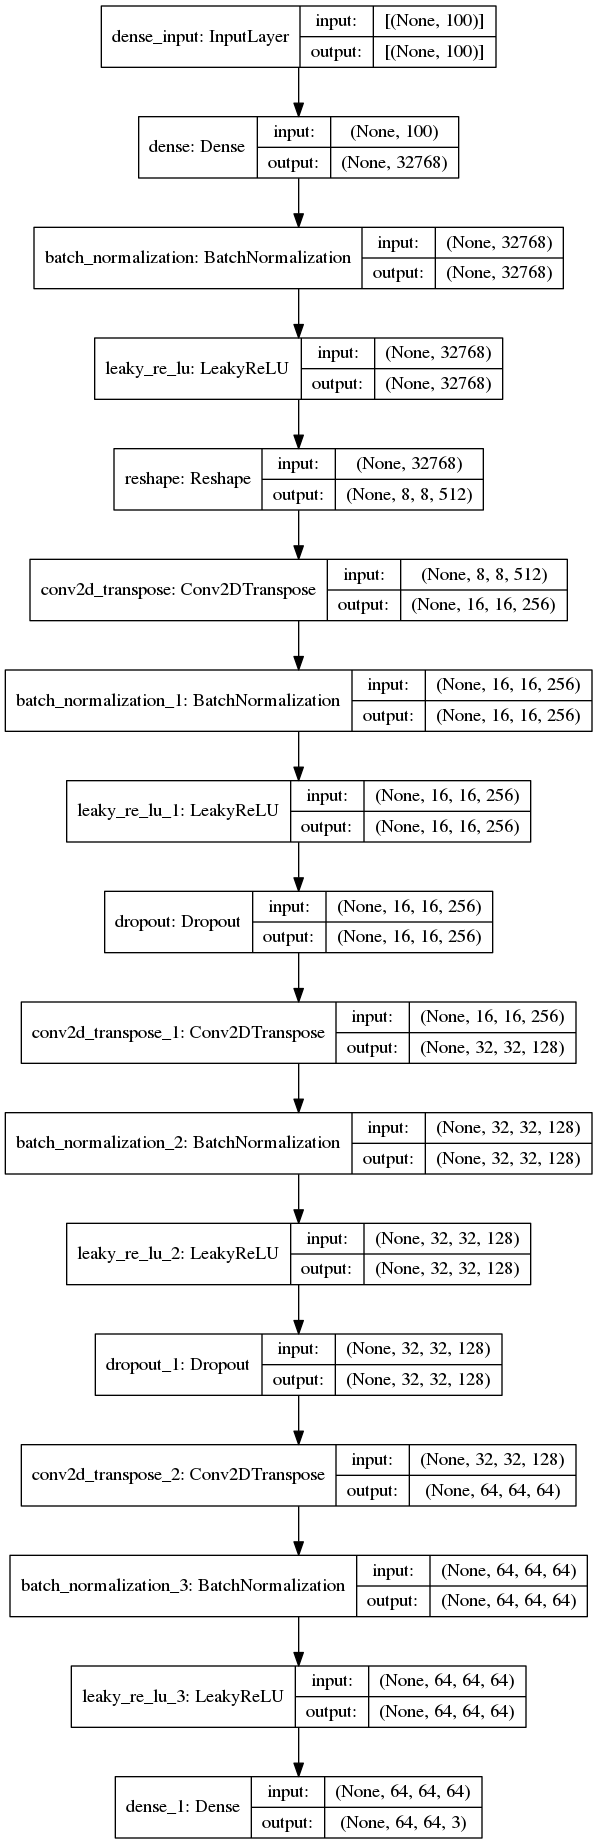

In [13]:
# Want to see nice image of the generator network architecture
display.Image(filename='/tmp/gen_mdl.png')

In [14]:
FileLinks('.')

./
  __output__.json
  __notebook__.ipynb

# Discriminator model

The discriminator is a regular CNN which will be used for real dog pictures from training data and fake ones generated by the generator. I am initializing weights in the first layer with standard deviation = WEIGHT_INIT_STDDEV which will be changing while optimizing for better performance. 

In [15]:
def make_discriminator():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[dim,dim,3],\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            # flatten input into 1-D and output a single a number from the last layer using sigmoid activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

discriminator = make_discriminator()
tf.keras.utils.plot_model(
    generator,
    to_file='/tmp/dis_mdl.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
)
print(discriminator.summary())
decision = discriminator(generated_image)
print (decision)
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)        

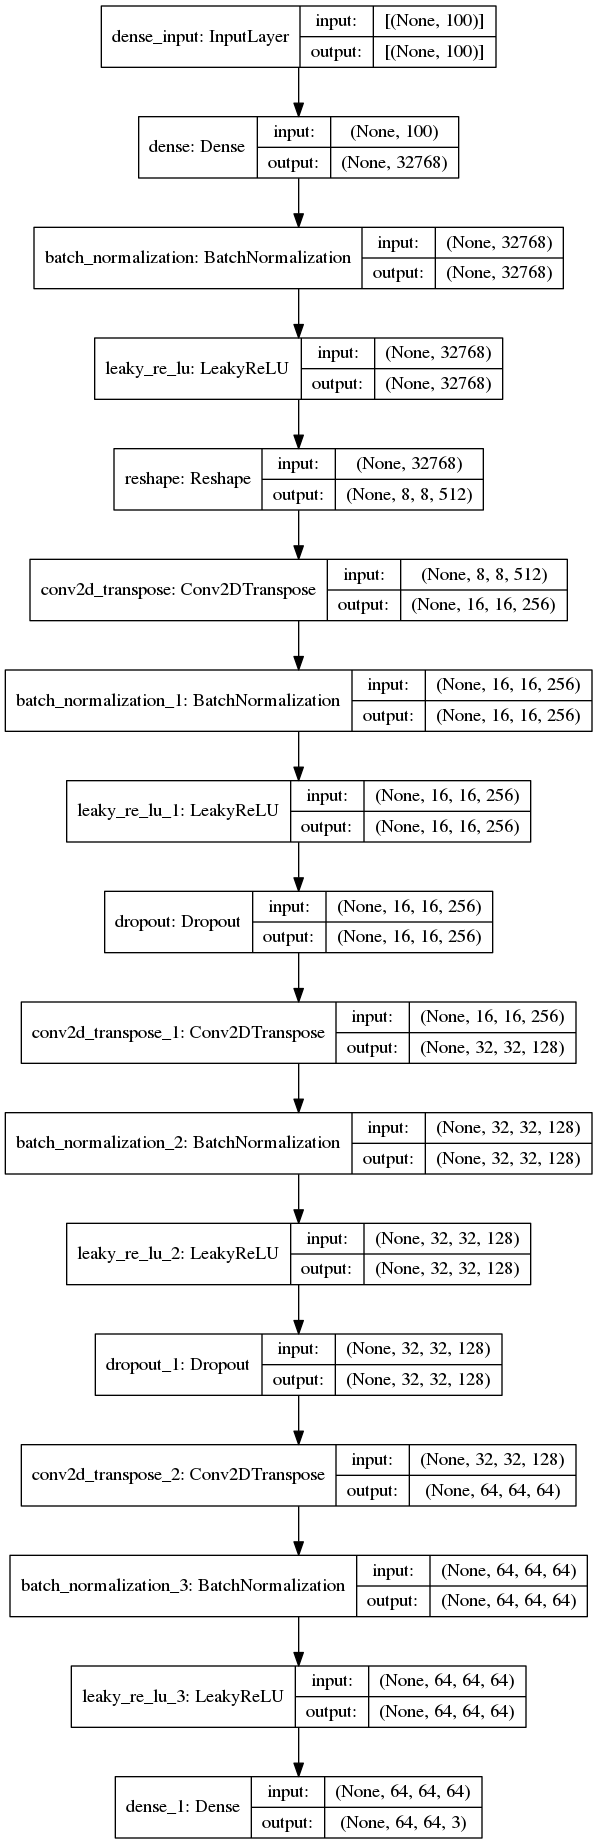

In [16]:
# discriminator model architecture picture
display.Image(filename='/tmp/dis_mdl.png')

# Loss and optimizers

Information on [AdamOptimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) and for [Binary Cross Entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a). 

BCE:
![](https://cdn-images-1.medium.com/max/960/1*rdBw0E-My8Gu3f_BOB6GMA.png)
Where y is the label (1 for yes and 0 for no). Great article explaining visually and the math behind it, check it out.

The discriminator loss function needs to compute loss for both real images and fake images then output the sum of both as the total loss. Generator loss is only the cross entropy of fake images. 



In [17]:
# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
# and [0.0, 0.3] for negative class

def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.3)

def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.5

# Recomended to introduce some noise to the labels, so out of 1000 real labels, approximately 50 should be flipped to 0 (5%)
# randomly flip some labels
def noisy_labels(y, p_flip):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0].value)
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0].value)], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

In [18]:
# This method returns a helper function to compute cross entropy loss
# code from tf dcgan tutorial
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# The Discriminator loss function

def discriminator_loss(real_output, fake_output):
    # tf.ones_like changes all values in the tensor to 1s
    # similarly tf.zeros_like changes all values in the tensor to 0
    # then apply label smoothing
    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
#     real_output_noisy = noisy_labels(real_output_smooth, 0.05)
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
#     fake_output_noisy = noisy_labels(fake_output_smooth, 0.05)
    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The Generator loss function

def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
#     fake_output_noisy = noisy_labels(fake_output_smooth, 0.05)
    return cross_entropy(fake_output_smooth, fake_output)

# optimizers -- Adam
generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)

# Training loop

In [19]:
# code from tf dcgan tutorial
def train_step(images, G_loss_list, D_loss_list):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # the following are the operations recorded onto the "tape"
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    G_loss_list.append(gen_loss.numpy())
    D_loss_list.append(disc_loss.numpy())
    # the following lines are taking the derivatives and applying gradients using Adam optimizer
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [20]:
def train(dataset, epochs):
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch, G_loss, D_loss)
            
        plot_loss(G_loss, D_loss, epoch)
        G_loss = []
        D_loss = []
        if (epoch % 10 == 0):
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
            
    # Generate after the final epoch
    print("Final Epoch")
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
import time
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)    
    fig = plt.figure(figsize=(8,8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1.)/2.)
        plt.axis('off')
#     plt.savefig('image_at_epoch_{}.png'.format(epoch+1))
    plt.show()

In [22]:
# function by Nanashi

def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch+1))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



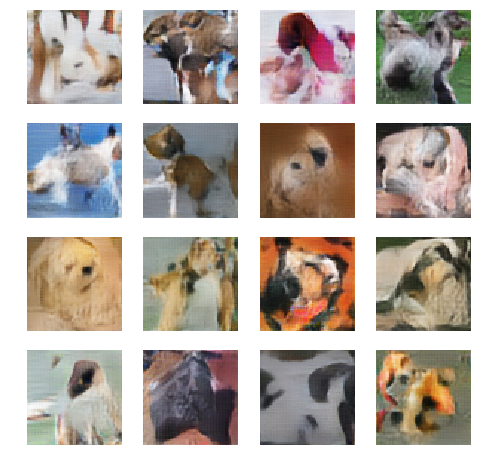

Time for epoch 271 is 87.07361578941345 sec


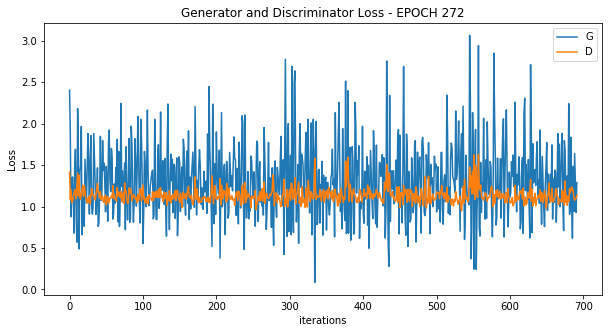

Time for epoch 272 is 86.2390685081482 sec


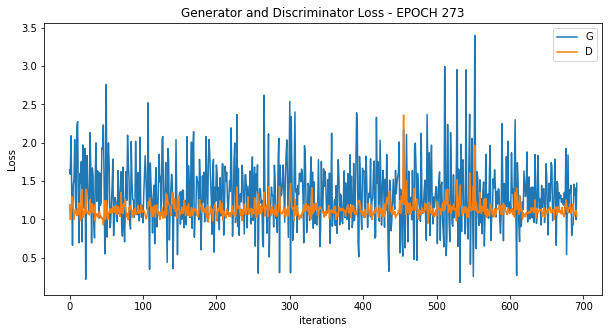

Time for epoch 273 is 87.08129644393921 sec


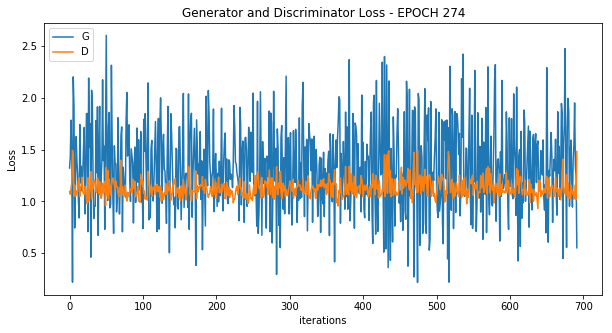

Time for epoch 274 is 86.38401889801025 sec


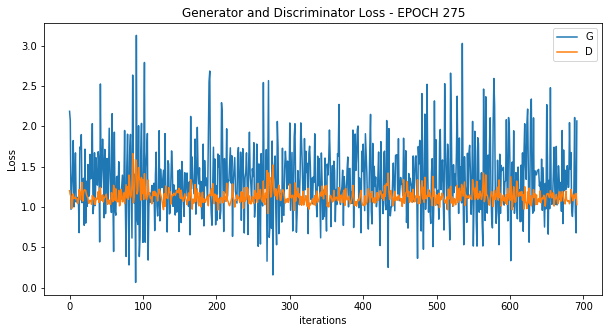

Time for epoch 275 is 86.95599365234375 sec


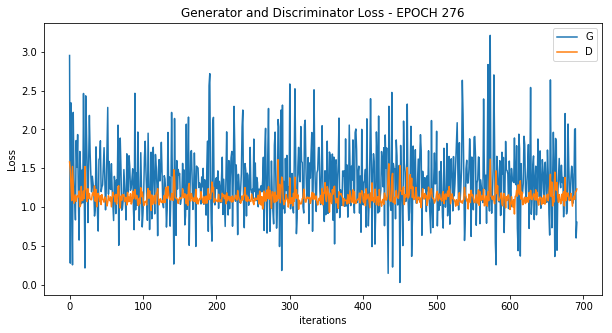

Time for epoch 276 is 89.19334816932678 sec


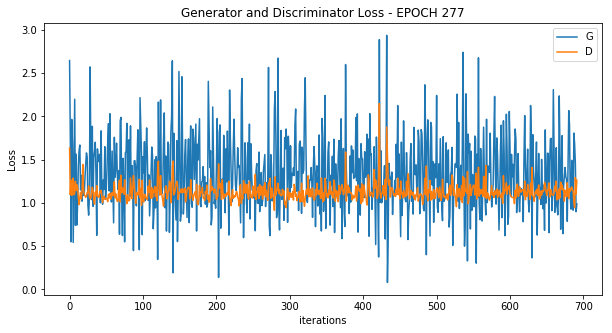

Time for epoch 277 is 90.03409767150879 sec


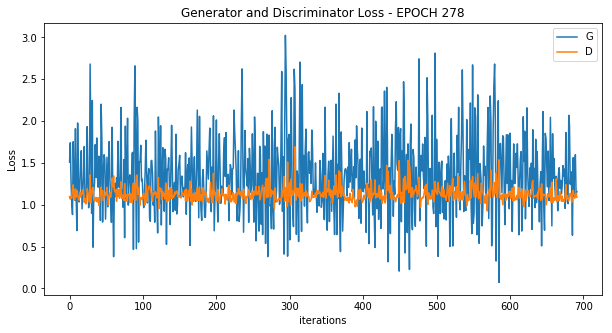

Time for epoch 278 is 90.13678312301636 sec


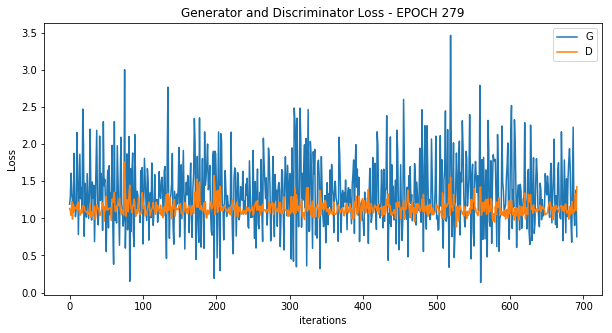

Time for epoch 279 is 88.2996551990509 sec


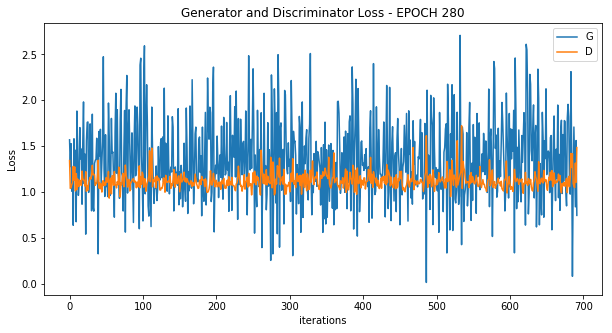

Time for epoch 280 is 88.3433530330658 sec
Final Epoch


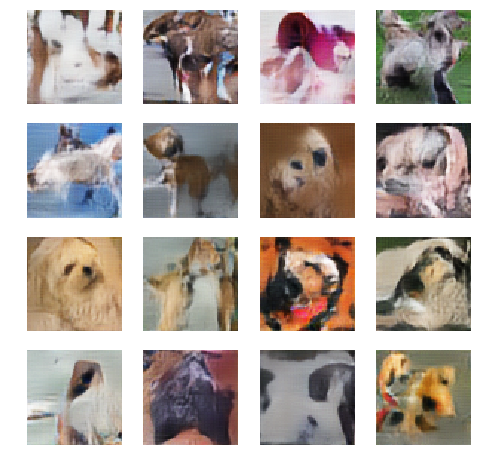

CPU times: user 4h 56min 24s, sys: 32min 41s, total: 5h 29min 5s
Wall time: 6h 44min 58s


In [23]:
%%time
print('Starting training')
train(ds, EPOCHS)


# Save 10000 generated dog images

In [24]:
%%time
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')

filename = 'gen_model.h5'
tf.keras.models.save_model(
    generator,
    filename,
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

for k in range(10000):
    generated_image = generator(tf.random.normal([1, noise_dim]), training=False)
    f = str(k)+'.png'
    img = ((generated_image[0,:,:,:]+1.)/2.).numpy()
    tf.keras.preprocessing.image.save_img(
        f,
        img,
        scale=True
    )
    z.write(f); os.remove(f)
z.close()



CPU times: user 1min 53s, sys: 9.27 s, total: 2min 2s
Wall time: 1min 51s


In [25]:
FileLinks('.')

./
  __output__.json
  images.zip
  __notebook__.ipynb
  gen_model.h5